# Experiments for Bachelor's Program in Business Informatics University of Mannheim
This notebook contains the experiments performed on the bachelor's program in business informatics of the University of Mannheim

## 1. Imports

In [1]:
import camelot
import pandas as pd
import tableExtraction as te
import graphCreation as gc
import re
import networkx as nx
import matplotlib.pyplot as plt
import sqlite3

## 2. Create Graph
### 2.1 Extract Course Tables from Module Handbooks

In [2]:
relevant_courses = te.get_relevant_courses("../02_Ressources/MK_BSc_Wifo_2020_21_Course_Overview.pdf")
courses = te.get_courses("../02_Ressources/MK_BSc_Wifo_2020_21_Courses.pdf")


paths = ["../02_Ressources/Modulkatalog_Nebenfach_BWL.pdf", "../02_Ressources/MK_BSc_Wima_2020_21.pdf"]
end_cells = ["Verwendbarkeit", "Einordnung in Fachsemester"]
coordinates = [[0,0],[0,1]]
courses.extend(te.get_additional_courses(relevant_courses, paths, end_cells, coordinates))

C:\Users\Paul\anaconda3\envs\master_thesis\lib\site-packages\camelot\utils.py:740: UserWarning:   (541.47, 544.182) does not lie in column range (65.52538683491369, 541.3654737903225)
  warnings.warn(
C:\Users\Paul\anaconda3\envs\master_thesis\lib\site-packages\camelot\utils.py:740: UserWarning:   (541.47, 544.182) does not lie in column range (65.52547473292196, 541.3654737903225)
  warnings.warn(
C:\Users\Paul\anaconda3\envs\master_thesis\lib\site-packages\camelot\utils.py:740: UserWarning:   (535.58, 538.292) does not lie in column range (71.03522406889036, 535.0440545877398)
  warnings.warn(
C:\Users\Paul\anaconda3\envs\master_thesis\lib\site-packages\camelot\utils.py:740: UserWarning:     (535.58, 538.292) does not lie in column range (71.03147798266829, 535.0440548166061)
  warnings.warn(
C:\Users\Paul\anaconda3\envs\master_thesis\lib\site-packages\camelot\utils.py:740: UserWarning:   (535.58, 538.292) does not lie in column range (71.03147798266829, 535.0440548166061)
  warnings

#export courses
courses = te.post_fixes(courses)

index = 0
for course in courses:
    name = "../03_Courses/" + "Course" + str(index) + ".xlsx"
    course.to_excel(name, index=False)
    index += 1

In [2]:
#import courses

courses = []
for i in range(0,54):
    #Exclude the international courses
    #if not (i == 16) and not (i == 24):
    path = "../03_Courses/Course" + str(i) + ".xlsx"
    df = pd.read_excel(path, dtype=str).fillna('')
    courses.append(df)

### 2.2 Creation of Nodes & Edges

In [3]:
G = nx.DiGraph()

course_nodes = gc.getCourseNodes(courses)
knowledge_nodes = pd.read_excel("../04_Graph/knowledgeAreas.xlsx").values.tolist()
edges_df = pd.read_excel("../04_Graph/edges.xlsx")
edges = edges_df.values.tolist()

In [4]:
#Create Course Nodes
for node in course_nodes:
    G.add_node(node[0], ECTS=node[1], offering_cycle=node[2], color="grey", type="course", active = False)

#Create Skill Nodes
for i in range(len(knowledge_nodes)):
    if i <= 16:
        G.add_node(knowledge_nodes[i][0], color="blue", type="skill", active = False)
    elif i > 16 and i <= 22:
        G.add_node(knowledge_nodes[i][0], color="green", type="skill", active = False)
    else:
        G.add_node(knowledge_nodes[i][0], color="brown", type="skill", active = False)

#print(G.nodes)

In [5]:
#Load manually created course -> skill edges
for edge in edges:
   G.add_edge(edge[0], edge[1], active = False)

additional_edges, additional_nodes = gc.complete_edges(courses, edges_df)

for node in additional_nodes:
    G.add_node(node[0], color = node[1], type = node[2], subtype = node[3], amount = node[4], active = False)

for edge in additional_edges:
    if len(edge) <= 2:
        G.add_edge(edge[0], edge[1], active = False)
    else:
        G.add_edge(edge[0], edge[1], weight = edge[2], active = False)

In [6]:
#Quality Checks for Attribute values

#for node, data in G.nodes(data=True):
    #print(f"Knoten {node}: name = {data.get('offering_cycle')}")
    #print(data.get('ECTS'))
    #if not (data.get('offering_cycle') == "FWS" or data.get('offering_cycle') =="SSS" or data.get('offering_cycle') == "Continuously"):
        #print(f"Knoten {node}: name = {data.get('offering_cycle')}")
    #print(f"Knoten {node}: name = {data.get('ECTS')}")

#for outgoing, ingoing, data in G.edges(data=True):
#    print(f"{outgoing} -> {ingoing}: weight = {data.get('weight')}")

#for outgoing, ingoing, data in G.edges(data=True):
    #if not data.get("weight") == None:
        #print(f"{outgoing} -> {ingoing}: weight = {data.get('ECTS')}")
    #print(data.get('ECTS'))

<function matplotlib.pyplot.show(close=None, block=None)>

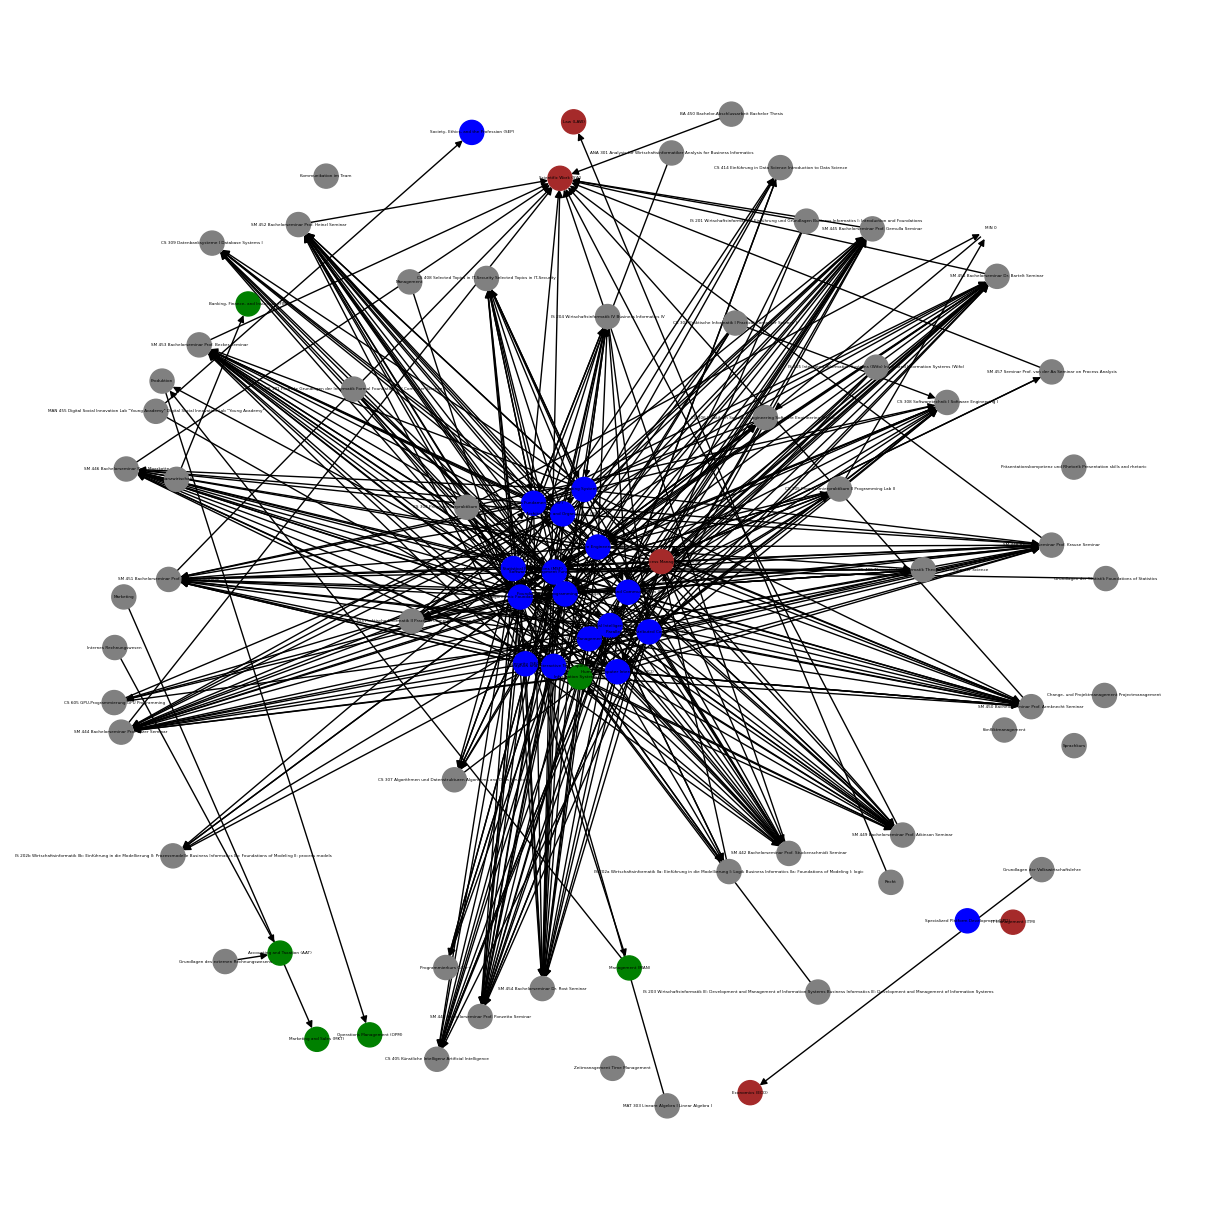

In [7]:
pos = nx.spring_layout(G, k=1) 

plt.figure(figsize=(12, 12))

node_colors = [G.nodes[node]['color'] for node in G.nodes()]

nx.draw(G, pos, with_labels=True, node_color=node_colors, font_size=3)

#nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)
plt.savefig("graph.pdf", format="pdf") 
plt.show

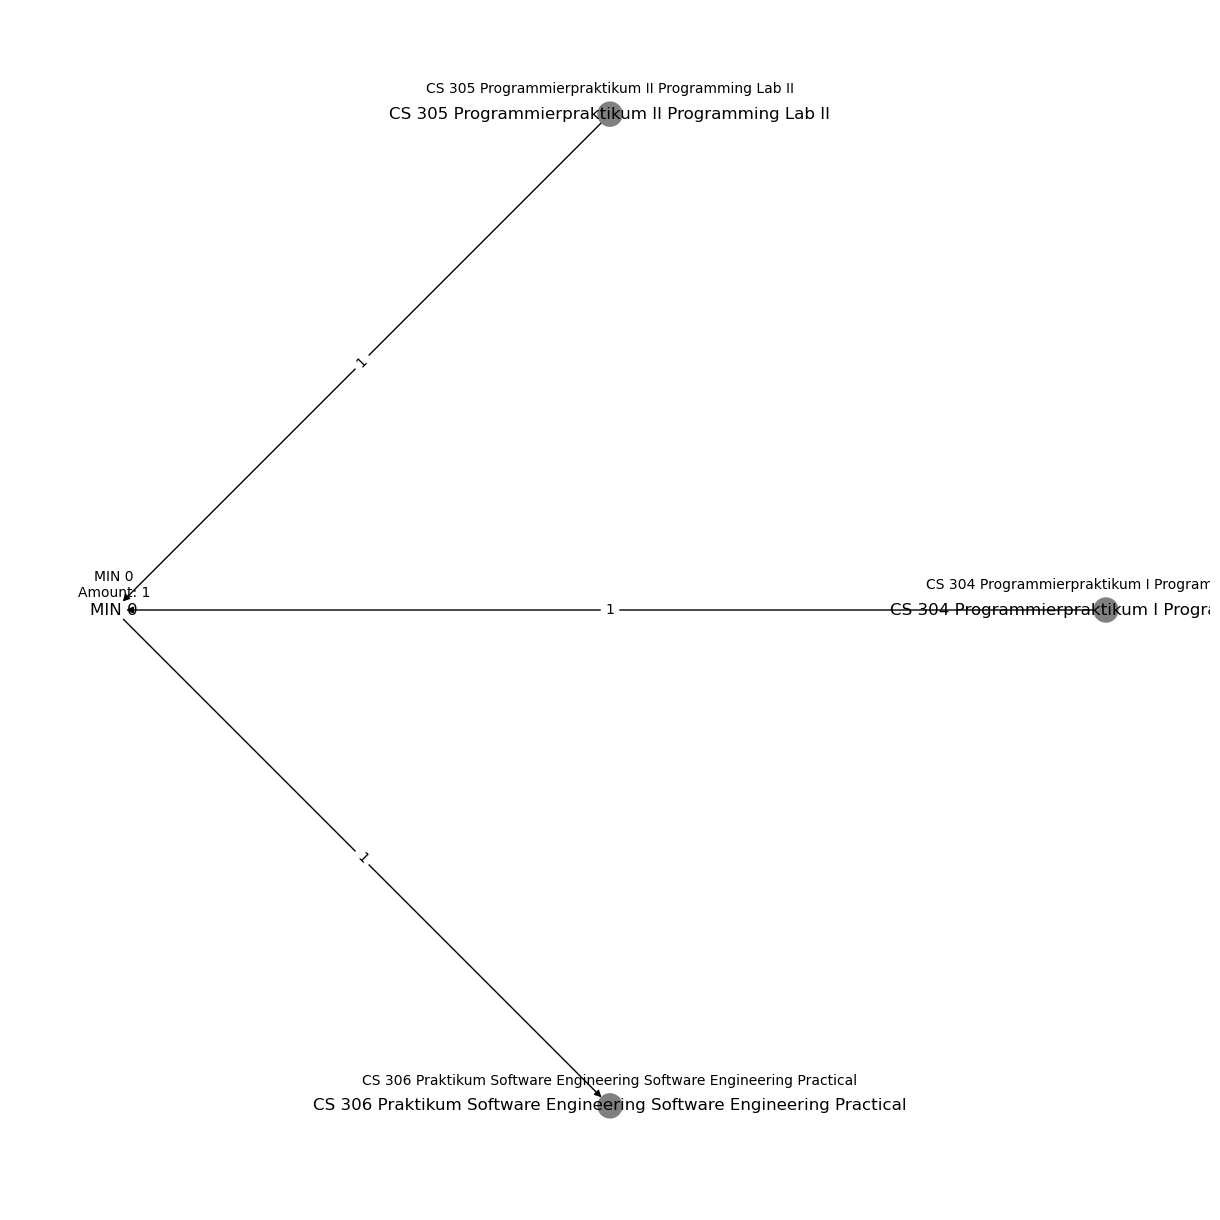

In [8]:
# Wähle den gewünschten Node, z.B. node_id
node_id = 'CS 307 Algorithmen und Datenstrukturen Algorithms and Data Structures'
node_id = 'MIN 0'

# Finde die Knoten, die mit dem ausgewählten Knoten verbunden sind (eingehend und ausgehend)
incoming_nodes = [n for n in G.predecessors(node_id)]  # Eingehende Knoten
outgoing_nodes = [n for n in G.successors(node_id)]  # Ausgehende Knoten

# Alle relevanten Knoten: der Knoten selbst, eingehende und ausgehende Nachbarn
subgraph_nodes = set([node_id] + incoming_nodes + outgoing_nodes)
#subgraph_nodes = set([node_id] + outgoing_nodes)
#subgraph_nodes = set([node_id] + incoming_nodes)

# Erzeuge den Subgraphen mit den gefundenen Knoten
subgraph = G.subgraph(subgraph_nodes)

# Positionen der Nodes berechnen (für den Subgraphen)
pos = nx.circular_layout(subgraph)

plt.figure(figsize=(12, 12))

# Farben der Nodes für den Subgraphen
node_colors = [subgraph.nodes[node]['color'] for node in subgraph.nodes()]

# Zeichne den Subgraphen
nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, font_size=12)

node_labels = {
    node: f"{node}\nAmount: {subgraph.nodes[node]['amount']}" 
    if 'amount' in subgraph.nodes[node] else node
    for node in subgraph.nodes()
}

offset = 0.05  # Verschiebung der Labels; kann angepasst werden
label_pos = {node: (pos[node][0], pos[node][1] + offset) for node in subgraph.nodes()}

# Zeichne die Labels mit den angepassten Positionen
nx.draw_networkx_labels(subgraph, label_pos, labels=node_labels, font_size=10)

edge_labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)


# Speichere das Ergebnis und zeige es an
plt.savefig("subgraph_with_edges.pdf", format="pdf")
plt.show()

### 2.3 Edge Weighting

In [10]:
#Match Course Names between Graph and Database

df_courseNames = pd.read_csv("../02_Ressources/DB_CourseNames.csv")

conn = sqlite3.connect('DB_CourseNames.db')
cursor = conn.cursor()

df_courseNames.to_sql('course_names', conn, if_exists='replace', index=False)

graph_courseNames = []
for course in courses:
    graph_courseNames.append(gc.mapGraphToDB_courseName(course))

matching_results = []

for graph_courseName in graph_courseNames:
    query = "SELECT kurs FROM course_names WHERE ? LIKE kurs || '%'" 
    cursor.execute(query, (graph_courseName,))
    results = cursor.fetchall()
    
    results_string = ', '.join([str(result[0]) for result in results])
    matching_results.append(graph_courseName + " matches: " + results_string)


query = "SELECT kurs FROM course_names" 
cursor.execute(query)
results = cursor.fetchall()
    

#for line in results:
#    print(line[0])

#print("\n")

for course_match in matching_results:
    if re.match(r".*matches: $", course_match):
        print(course_match)

conn.close()

SM 451 Bachelorseminar Prof. Paulheim Seminar matches: 
BA 450 Bachelor-Abschlussarbeit Bachelor Thesis matches: 
